In [3]:
from selenium.webdriver import Chrome 
from bs4 import BeautifulSoup
import pymongo
import datetime
import time 
import pandas as pd
import re

In [4]:
mc = pymongo.MongoClient()

db = mc['chordify']

raw_html = db['raw_html']

In [97]:
raw_html.find().count()

2060

In [6]:
html_docs = list(raw_html.find())

In [18]:
def get_lines_from_song(html_doc):
    if 'html' in html_doc:
        html = html_doc['html']
    elif 'song_html' in html_doc:
        html = html_doc['song_html']
    else:
        raise KeyError (f"Html not found for {html_doc.get('_id')}")
    soup = BeautifulSoup(html, 'html.parser')
    song_body = soup.select_one('pre._1YgOS')
    song_lines = str(song_body).split('\n')
    return song_lines


def strip_html(text):
    result = []
    in_tag = False
    for char in text:
        if char == '<':
            in_tag = True
        if not in_tag:
            result.append(char)
        if char == '>':
            in_tag = False
    return ''.join(result)


def separate_lines(html_doc):
    song_lines = get_lines_from_song(html_doc)
    lines = []
    for i, song_line in enumerate(song_lines):
        if '_3L0Da' in song_line:
            lines.append({'chords': strip_html(song_line)})
        elif (('_3L0Da' in song_lines[i-1]) and (song_line == song_line) and (strip_html(song_line) == song_line)):
            lines[-1]['words'] = song_line
    return lines


def get_chords(line):
    chord_idxs = []
    chords = []
    c_string = line['chords']
    for chord in re.finditer('\w+', c_string):
        chord_idxs.append(chord.start())
        chords.append(chord.group())
    chord_tups = list(zip(chord_idxs, chords))
    return chord_idxs, chords, chord_tups


def get_words(line):
    word_idxs = []
    words = []
    if 'words'in line:
        w_string = line['words']
        for word in re.finditer('\w+', w_string):
            word_idxs.append(word.start())
            words.append(word.group())
    word_tups = list(zip(word_idxs, words))
    return word_idxs, words, word_tups


def merge_chord_word(line):
    chord_tups = get_chords(line)[2]
    word_tups = get_words(line)[2]
    word_list = get_words(line)[1]
    chord_idx_list = []
    for chord_tup in chord_tups:
        for i, word_tup in enumerate(word_tups):
            if word_tup[0] > chord_tup[0]:
                chord_idx_list.append((i-1, chord_tup[1]))
                break
    return (chord_idx_list, word_list)


def combine_ch_wd_lists(merged_line_1, merged_line_2):
    chord_idx_list_1, word_list_1 = merged_line_1
    chord_idx_list_2, word_list_2 = merged_line_2
    new_chord_tups = []
    for chord_idx_tup in chord_idx_list_2:
        new_chord_tups.append( ( ( (chord_idx_tup)[0] + len(word_list_1) ), chord_idx_tup[1] ) )
    all_chords_tups = chord_idx_list_1 + new_chord_tups
    all_words_list = word_list_1 + word_list_2
    return all_chords_tups, all_words_list


def parse_lines(lines):
    for i, line in enumerate(lines):
        if i == 0:
            parsed_line = merge_chord_word(line)
        else:
            parsed_line_next = merge_chord_word(line)
            parsed_line = combine_ch_wd_lists(parsed_line, parsed_line_next)
    return parsed_line 

In [19]:
def parse_song(html_doc):
    lines = separate_lines(html_doc)
    parsed_song = parse_lines(lines)
    return parsed_song 

{'_id': ObjectId('5af47b9186b136b3a2705031'),
 'datetime': datetime.datetime(2018, 5, 10, 10, 4, 17, 367000),
 'html': '<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en"><head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# article: http://ogp.me/ns/article#"><script async="" type="text/javascript" src="//www.googletagservices.com/tag/js/gpt.js"></script><script src="https://pagead2.googlesyndication.com/pagead/osd.js"></script><script src="https://securepubads.g.doubleclick.net/gpt/pubads_impl_rendering_203.js"></script><script type="text/javascript" async="" src="//www.googletagservices.com/tag/js/gpt.js"></script>\n    <meta property="fb:app_id" content="539490962762175" />\n<meta property="og:type" content="article" />\n<meta property="og:title" content="Bob Dylan - All Along The Watchtower (Chords)" />\n<meta property="og:description" content="CHORDS (ver 4) by Bob Dylan" />\n<meta property="og:image" content="https://tabs.ultimate-guitar.com/static/_img/u
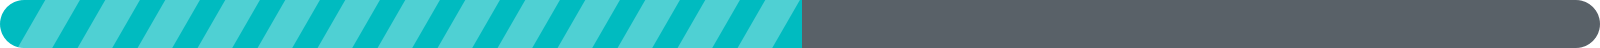

In [49]:
doc = html_docs[33]
doc

In [45]:
one_song = parse_song(html_docs[33])

In [21]:
some_docs = html_docs[5:8]

In [22]:
def parse_many(some_docs):
    parsed_songs = []
    for some_doc in some_docs:
        try:
            parsed_song = parse_song(some_doc)
            parsed_songs.append(parsed_song)
        except KeyError as e:
            warnings.warn(e.message)
            continue 
    return parsed_songs 

In [63]:
parsed_songs = parse_many(some_docs)
parsed_songs

[([(1, 'G'), (6, 'C'), (11, 'C'), (20, 'C'), (29, 'G'), (33, 'D')],
  ['I',
   'went',
   'to',
   'the',
   'doctor',
   'he',
   'says',
   'I',
   'm',
   'alright',
   'I',
   'knew',
   'he',
   'was',
   'lyin',
   'I',
   'm',
   'losing',
   'my',
   'sight',
   'He',
   'should',
   'have',
   'examined',
   'the',
   'eyes',
   'of',
   'my',
   'mind',
   '20',
   '20',
   'vision',
   'and',
   'walkin',
   'round',
   'blind']),
 ([(0, 'E'),
   (1, 'A'),
   (5, 'E'),
   (7, 'A'),
   (13, 'A'),
   (18, 'E'),
   (19, 'A'),
   (22, 'E'),
   (23, 'A'),
   (28, 'A'),
   (36, 'B7'),
   (49, 'E'),
   (51, 'A'),
   (55, 'A'),
   (58, 'E'),
   (64, 'E'),
   (69, 'A'),
   (73, 'A'),
   (75, 'E'),
   (78, 'E'),
   (79, 'A'),
   (80, 'E'),
   (82, 'A'),
   (84, 'E'),
   (87, 'A'),
   (95, 'F'),
   (97, 'E'),
   (99, 'A'),
   (102, 'E'),
   (103, 'A'),
   (106, 'A'),
   (109, 'E'),
   (112, 'E'),
   (117, 'E'),
   (121, 'A'),
   (125, 'A'),
   (127, 'E'),
   (128, 'A'),
   (130, 'E'),


In [36]:
type(parsed_songs)

list

In [33]:
ps = parsed_songs[2]
ps[1]

['Take',
 'a',
 'trip',
 'with',
 'me',
 'in',
 '1913',
 'To',
 'Calumet',
 'Michigan',
 'in',
 'the',
 'copper',
 'country',
 'I',
 'll',
 'take',
 'you',
 'to',
 'a',
 'place',
 'called',
 'Italian',
 'Hall']

In [37]:
parsed_songs[1]

([(0, 'E'),
  (1, 'A'),
  (5, 'E'),
  (7, 'A'),
  (13, 'A'),
  (18, 'E'),
  (19, 'A'),
  (22, 'E'),
  (23, 'A'),
  (28, 'A'),
  (36, 'B7'),
  (49, 'E'),
  (51, 'A'),
  (55, 'A'),
  (58, 'E'),
  (64, 'E'),
  (69, 'A'),
  (73, 'A'),
  (75, 'E'),
  (78, 'E'),
  (79, 'A'),
  (80, 'E'),
  (82, 'A'),
  (84, 'E'),
  (87, 'A'),
  (95, 'F'),
  (97, 'E'),
  (99, 'A'),
  (102, 'E'),
  (103, 'A'),
  (106, 'A'),
  (109, 'E'),
  (112, 'E'),
  (117, 'E'),
  (121, 'A'),
  (125, 'A'),
  (127, 'E'),
  (128, 'A'),
  (130, 'E'),
  (130, 'A'),
  (131, 'E'),
  (133, 'A'),
  (136, 'E'),
  (139, 'B7'),
  (154, 'E'),
  (157, 'A'),
  (163, 'A'),
  (165, 'E'),
  (167, 'E'),
  (168, 'A'),
  (171, 'E'),
  (175, 'A'),
  (178, 'E'),
  (180, 'A'),
  (182, 'E'),
  (184, 'E'),
  (186, 'A'),
  (187, 'E'),
  (191, 'A'),
  (195, 'E'),
  (198, 'B7'),
  (212, 'E'),
  (215, 'A'),
  (219, 'A'),
  (223, 'E'),
  (227, 'E'),
  (232, 'E'),
  (233, 'A'),
  (237, 'A'),
  (238, 'E'),
  (242, 'E'),
  (243, 'A'),
  (244, 'E'),
  (245,

In [48]:
one_song

([(-1, 'Intro'),
  (-1, 'Am'),
  (-1, 'G'),
  (-1, 'F'),
  (-1, 'G'),
  (5, 'Am'),
  (9, 'G'),
  (11, 'F'),
  (13, 'Am'),
  (16, 'G'),
  (19, 'Am'),
  (23, 'G'),
  (24, 'Am'),
  (28, 'G'),
  (30, 'Am'),
  (32, 'G'),
  (34, 'F'),
  (36, 'Am'),
  (37, 'G'),
  (40, 'Am'),
  (44, 'G'),
  (45, 'F'),
  (47, 'Am'),
  (50, 'G'),
  (54, 'Am'),
  (57, 'G'),
  (59, 'Am'),
  (62, 'G'),
  (64, 'Am'),
  (67, 'G'),
  (69, 'F'),
  (70, 'Am'),
  (74, 'G'),
  (78, 'Am'),
  (82, 'G'),
  (85, 'F'),
  (87, 'Am'),
  (90, 'G'),
  (93, 'Am'),
  (97, 'G'),
  (99, 'F'),
  (100, 'Am'),
  (103, 'G'),
  (105, 'Am'),
  (107, 'G'),
  (109, 'Am'),
  (111, 'G'),
  (114, 'Am'),
  (118, 'G'),
  (119, 'F'),
  (121, 'Am'),
  (123, 'G'),
  (124, 'Am'),
  (126, 'G'),
  (128, 'Am'),
  (131, 'G'),
  (133, 'Am'),
  (136, 'G'),
  (137, 'Am'),
  (140, 'G')],
 ['quick',
  'transtion',
  'through',
  'G',
  'to',
  'Am',
  'There',
  'must',
  'be',
  'some',
  'way',
  'out',
  'of',
  'here',
  'Said',
  'the',
  'joker',
  'to'

In [47]:
one_song

([(-1, 'Intro'),
  (-1, 'Am'),
  (-1, 'G'),
  (-1, 'F'),
  (-1, 'G'),
  (5, 'Am'),
  (9, 'G'),
  (11, 'F'),
  (13, 'Am'),
  (16, 'G'),
  (19, 'Am'),
  (23, 'G'),
  (24, 'Am'),
  (28, 'G'),
  (30, 'Am'),
  (32, 'G'),
  (34, 'F'),
  (36, 'Am'),
  (37, 'G'),
  (40, 'Am'),
  (44, 'G'),
  (45, 'F'),
  (47, 'Am'),
  (50, 'G'),
  (54, 'Am'),
  (57, 'G'),
  (59, 'Am'),
  (62, 'G'),
  (64, 'Am'),
  (67, 'G'),
  (69, 'F'),
  (70, 'Am'),
  (74, 'G'),
  (78, 'Am'),
  (82, 'G'),
  (85, 'F'),
  (87, 'Am'),
  (90, 'G'),
  (93, 'Am'),
  (97, 'G'),
  (99, 'F'),
  (100, 'Am'),
  (103, 'G'),
  (105, 'Am'),
  (107, 'G'),
  (109, 'Am'),
  (111, 'G'),
  (114, 'Am'),
  (118, 'G'),
  (119, 'F'),
  (121, 'Am'),
  (123, 'G'),
  (124, 'Am'),
  (126, 'G'),
  (128, 'Am'),
  (131, 'G'),
  (133, 'Am'),
  (136, 'G'),
  (137, 'Am'),
  (140, 'G')],
 ['quick',
  'transtion',
  'through',
  'G',
  'to',
  'Am',
  'There',
  'must',
  'be',
  'some',
  'way',
  'out',
  'of',
  'here',
  'Said',
  'the',
  'joker',
  'to'

In [71]:
def get_phrase_for_chord(one_song):
    word_list = one_song[1]
    phrase_tups = []
    for chord_tuple in one_song[0]:
        word_idx = chord_tuple[0]
        chord_name = chord_tuple[1]
        phrase = word_list[(word_idx - 10):(word_idx + 3)]
        phrase_tups.append((chord_name, phrase))
    return phrase_tups

In [69]:
get_phrase_for_chord(one_song)

[('F', []),
 ('F', []),
 ('Dm',
  ['sun',
   'One',
   'by',
   'one',
   'until',
   'there',
   'were',
   'none',
   'Two',
   'by',
   'two',
   'to',
   'their']),
 ('C',
  ['until',
   'there',
   'were',
   'none',
   'Two',
   'by',
   'two',
   'to',
   'their',
   'lovers',
   'they',
   'flew',
   'Two']),
 ('Dm',
  ['Two',
   'by',
   'two',
   'to',
   'their',
   'lovers',
   'they',
   'flew',
   'Two',
   'by',
   'two',
   'into',
   'the']),
 ('C',
  ['to',
   'their',
   'lovers',
   'they',
   'flew',
   'Two',
   'by',
   'two',
   'into',
   'the',
   'foggy',
   'dew',
   'Three']),
 ('F',
  ['flew',
   'Two',
   'by',
   'two',
   'into',
   'the',
   'foggy',
   'dew',
   'Three',
   'by',
   'three',
   'they',
   'danced']),
 ('F',
  ['Three',
   'by',
   'three',
   'they',
   'danced',
   'on',
   'the',
   'sea',
   'Four',
   'by',
   'four',
   'they',
   'danced']),
 ('Dm',
  ['Four',
   'by',
   'four',
   'they',
   'danced',
   'on',
   'the',
   'sh

In [46]:
one_song

([(-1, 'Intro'),
  (-1, 'Am'),
  (-1, 'G'),
  (-1, 'F'),
  (-1, 'G'),
  (5, 'Am'),
  (9, 'G'),
  (11, 'F'),
  (13, 'Am'),
  (16, 'G'),
  (19, 'Am'),
  (23, 'G'),
  (24, 'Am'),
  (28, 'G'),
  (30, 'Am'),
  (32, 'G'),
  (34, 'F'),
  (36, 'Am'),
  (37, 'G'),
  (40, 'Am'),
  (44, 'G'),
  (45, 'F'),
  (47, 'Am'),
  (50, 'G'),
  (54, 'Am'),
  (57, 'G'),
  (59, 'Am'),
  (62, 'G'),
  (64, 'Am'),
  (67, 'G'),
  (69, 'F'),
  (70, 'Am'),
  (74, 'G'),
  (78, 'Am'),
  (82, 'G'),
  (85, 'F'),
  (87, 'Am'),
  (90, 'G'),
  (93, 'Am'),
  (97, 'G'),
  (99, 'F'),
  (100, 'Am'),
  (103, 'G'),
  (105, 'Am'),
  (107, 'G'),
  (109, 'Am'),
  (111, 'G'),
  (114, 'Am'),
  (118, 'G'),
  (119, 'F'),
  (121, 'Am'),
  (123, 'G'),
  (124, 'Am'),
  (126, 'G'),
  (128, 'Am'),
  (131, 'G'),
  (133, 'Am'),
  (136, 'G'),
  (137, 'Am'),
  (140, 'G')],
 ['quick',
  'transtion',
  'through',
  'G',
  'to',
  'Am',
  'There',
  'must',
  'be',
  'some',
  'way',
  'out',
  'of',
  'here',
  'Said',
  'the',
  'joker',
  'to'

In [42]:
def get_all_lyrics_chords(song):
    song_lyrics = ' '.join(song[1])
    song_chords = []
    for ch_tup in song[0]:
        song_chords.append(ch_tup[1])
    return song_lyrics, song_chords 

In [90]:
paragraph, ch_lst = get_all_lyrics_chords(one_song)

In [91]:
paragraph

'quick transtion through G to Am There must be some way out of here Said the joker to the thief There s too much confusion I can t get no relief Business men they drink my wine Plowmen dig my earth But none of them along the line Know what any of it is worth No reason to get excited The thief he kindly spoke There are many here among us Who feel that life is but a joke But you and I we ve been through that And this is not our fate So let us not talk falsely now The hour is getting late All along the watchtower The princes kept the view While all the women came and went Barefoot servants too Outside in the distance A wild cat did growl Two riders were approaching The wind began to howl'

In [51]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

input_string = remove_accents(paragraph)

In [52]:
from nltk.tokenize import sent_tokenize

sent_tokens = sent_tokenize(input_string)

sent_tokens

['quick transtion through G to Am There must be some way out of here Said the joker to the thief There s too much confusion I can t get no relief Business men they drink my wine Plowmen dig my earth But none of them along the line Know what any of it is worth No reason to get excited The thief he kindly spoke There are many here among us Who feel that life is but a joke But you and I we ve been through that And this is not our fate So let us not talk falsely now The hour is getting late All along the watchtower The princes kept the view While all the women came and went Barefoot servants too Outside in the distance A wild cat did growl Two riders were approaching The wind began to howl']

In [53]:
from nltk.tokenize import word_tokenize

tokens = [sent for sent in map(word_tokenize, sent_tokens)]

list(enumerate(tokens))

[(0,
  ['quick',
   'transtion',
   'through',
   'G',
   'to',
   'Am',
   'There',
   'must',
   'be',
   'some',
   'way',
   'out',
   'of',
   'here',
   'Said',
   'the',
   'joker',
   'to',
   'the',
   'thief',
   'There',
   's',
   'too',
   'much',
   'confusion',
   'I',
   'can',
   't',
   'get',
   'no',
   'relief',
   'Business',
   'men',
   'they',
   'drink',
   'my',
   'wine',
   'Plowmen',
   'dig',
   'my',
   'earth',
   'But',
   'none',
   'of',
   'them',
   'along',
   'the',
   'line',
   'Know',
   'what',
   'any',
   'of',
   'it',
   'is',
   'worth',
   'No',
   'reason',
   'to',
   'get',
   'excited',
   'The',
   'thief',
   'he',
   'kindly',
   'spoke',
   'There',
   'are',
   'many',
   'here',
   'among',
   'us',
   'Who',
   'feel',
   'that',
   'life',
   'is',
   'but',
   'a',
   'joke',
   'But',
   'you',
   'and',
   'I',
   'we',
   've',
   'been',
   'through',
   'that',
   'And',
   'this',
   'is',
   'not',
   'our',
   'fate

In [54]:
import string

tokens_lower = [[word.lower() for word in sent]
                 for sent in tokens]

In [55]:
from nltk.corpus import stopwords

stopwords_ = "a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your]".split(',')

print("--- stopwords in english: {}".format(stopwords_))

--- stopwords in english: ['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'but', 'by', 'can', 'could', 'dear', 'did', 'do', 'does', 'either', 'else', 'ever', 'every', 'for', 'from', 'get', 'got', 'had', 'has', 'have', 'he', 'her', 'hers', 'him', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 'like', 'likely', 'may', 'me', 'might', 'most', 'must', 'my', 'neither', 'no', 'of', 'off', 'often', 'on', 'only', 'or', 'other', 'our', 'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'tis', 'to', 'too', 'twas', 'us', 'wants', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet', 'you', 'your]']


In [56]:
import string

punctuation_ = set(string.punctuation)
print("--- punctuation: {}".format(string.punctuation))

def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_])

tokens_filtered = list(map(filter_tokens, tokens_lower))

for sent in tokens_filtered:
    print("--- sentence tokens: {}".format(sent))

--- punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
--- sentence tokens: ['quick', 'transtion', 'through', 'g', 'way', 'out', 'here', 'joker', 'thief', 's', 'much', 'confusion', 't', 'relief', 'business', 'men', 'drink', 'wine', 'plowmen', 'dig', 'earth', 'none', 'along', 'line', 'know', 'worth', 'reason', 'excited', 'thief', 'kindly', 'spoke', 'many', 'here', 'feel', 'life', 'joke', 've', 'through', 'not', 'fate', 'not', 'talk', 'falsely', 'now', 'hour', 'getting', 'late', 'along', 'watchtower', 'princes', 'kept', 'view', 'women', 'came', 'went', 'barefoot', 'servants', 'outside', 'distance', 'wild', 'cat', 'growl', 'two', 'riders', 'approaching', 'wind', 'began', 'howl']


In [62]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

stemmer_porter = PorterStemmer()
tokens_stemporter = [list(map(stemmer_porter.stem, sent)) for sent in tokens_filtered]
print("--- sentence tokens (porter): {}".format(tokens_stemporter[0]))

stemmer_snowball = SnowballStemmer('english')
tokens_stemsnowball = [list(map(stemmer_snowball.stem, sent)) for sent in tokens_filtered]
print("--- sentence tokens (snowball): {}".format(tokens_stemsnowball[0]))

--- sentence tokens (porter): ['quick', 'transtion', 'through', 'g', 'way', 'out', 'here', 'joker', 'thief', 's', 'much', 'confus', 't', 'relief', 'busi', 'men', 'drink', 'wine', 'plowmen', 'dig', 'earth', 'none', 'along', 'line', 'know', 'worth', 'reason', 'excit', 'thief', 'kindli', 'spoke', 'mani', 'here', 'feel', 'life', 'joke', 've', 'through', 'not', 'fate', 'not', 'talk', 'fals', 'now', 'hour', 'get', 'late', 'along', 'watchtow', 'princ', 'kept', 'view', 'women', 'came', 'went', 'barefoot', 'servant', 'outsid', 'distanc', 'wild', 'cat', 'growl', 'two', 'rider', 'approach', 'wind', 'began', 'howl']
--- sentence tokens (snowball): ['quick', 'transtion', 'through', 'g', 'way', 'out', 'here', 'joker', 'thief', 's', 'much', 'confus', 't', 'relief', 'busi', 'men', 'drink', 'wine', 'plowmen', 'dig', 'earth', 'none', 'along', 'line', 'know', 'worth', 'reason', 'excit', 'thief', 'kind', 'spoke', 'mani', 'here', 'feel', 'life', 'joke', 've', 'through', 'not', 'fate', 'not', 'talk', 'fals'

In [59]:
from nltk.util import ngrams

list(ngrams(tokens_stemsnowball[0],4))

[('quick', 'transtion', 'through', 'g'),
 ('transtion', 'through', 'g', 'way'),
 ('through', 'g', 'way', 'out'),
 ('g', 'way', 'out', 'here'),
 ('way', 'out', 'here', 'joker'),
 ('out', 'here', 'joker', 'thief'),
 ('here', 'joker', 'thief', 's'),
 ('joker', 'thief', 's', 'much'),
 ('thief', 's', 'much', 'confus'),
 ('s', 'much', 'confus', 't'),
 ('much', 'confus', 't', 'relief'),
 ('confus', 't', 'relief', 'busi'),
 ('t', 'relief', 'busi', 'men'),
 ('relief', 'busi', 'men', 'drink'),
 ('busi', 'men', 'drink', 'wine'),
 ('men', 'drink', 'wine', 'plowmen'),
 ('drink', 'wine', 'plowmen', 'dig'),
 ('wine', 'plowmen', 'dig', 'earth'),
 ('plowmen', 'dig', 'earth', 'none'),
 ('dig', 'earth', 'none', 'along'),
 ('earth', 'none', 'along', 'line'),
 ('none', 'along', 'line', 'know'),
 ('along', 'line', 'know', 'worth'),
 ('line', 'know', 'worth', 'reason'),
 ('know', 'worth', 'reason', 'excit'),
 ('worth', 'reason', 'excit', 'thief'),
 ('reason', 'excit', 'thief', 'kind'),
 ('excit', 'thief', 'k

In [61]:
from nltk.util import ngrams

def join_sent_ngrams(input_tokens, n):
    # first add the 1-gram tokens
    ret_list = list(input_tokens)
    
    #then for each n
    for i in range(2,n+1):
        # add each n-grams to the list
        ret_list.extend(['-'.join(tgram) for tgram in ngrams(input_tokens, i)])
    
    return(ret_list)

tokens_ngrams = list(map(lambda x : join_sent_ngrams(x, 3), tokens_stemsnowball))

print("--- sentence tokens: {}".format(tokens_ngrams[0]))

--- sentence tokens: ['quick', 'transtion', 'through', 'g', 'way', 'out', 'here', 'joker', 'thief', 's', 'much', 'confus', 't', 'relief', 'busi', 'men', 'drink', 'wine', 'plowmen', 'dig', 'earth', 'none', 'along', 'line', 'know', 'worth', 'reason', 'excit', 'thief', 'kind', 'spoke', 'mani', 'here', 'feel', 'life', 'joke', 've', 'through', 'not', 'fate', 'not', 'talk', 'fals', 'now', 'hour', 'get', 'late', 'along', 'watchtow', 'princ', 'kept', 'view', 'women', 'came', 'went', 'barefoot', 'servant', 'outsid', 'distanc', 'wild', 'cat', 'growl', 'two', 'rider', 'approach', 'wind', 'began', 'howl', 'quick-transtion', 'transtion-through', 'through-g', 'g-way', 'way-out', 'out-here', 'here-joker', 'joker-thief', 'thief-s', 's-much', 'much-confus', 'confus-t', 't-relief', 'relief-busi', 'busi-men', 'men-drink', 'drink-wine', 'wine-plowmen', 'plowmen-dig', 'dig-earth', 'earth-none', 'none-along', 'along-line', 'line-know', 'know-worth', 'worth-reason', 'reason-excit', 'excit-thief', 'thief-kind

In [67]:
import os               # for environ variables in Part 3
from nlp_pipeline import extract_bow_from_raw_text
# import json

# docs = []
# with open('./reviews.json', 'r') as data_file:    
#     for line in data_file:
#         docs.append(json.loads(line))

# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row['paragraph']), parsed_songs)

# displaying bows
for i in range(len(parsed_songs)):
#     print("\n--- review: {}".format(docs[i]['reviewText']))
    print("--- bow: {}".format(bows[i]))

SyntaxError: invalid syntax (<ipython-input-67-112357aecaf7>, line 14)

In [96]:
for song in parsed_songs:
    lyrics = get_all_lyrics_chords(song)[0]
    return lyrics 
    
def get_all_lyrics_chords(song):
song_lyrics = ' '.join(song[1])
song_chords = []
for ch_tup in song[0]:
    song_chords.append(ch_tup[1])
return (song_lyrics, song_chords) 

In [74]:
one_song_words = one_song[1]

In [82]:
cd .. 

/Users/emilynaftalin/galvanize/dsi/capstone/Guitar-Chord-Generator


In [83]:
from src.nlp_pipeline import extract_bow_from_raw_text
bows = lambda row: extract_bow_from_raw_text(row['paragraph'])

In [92]:
bows = extract_bow_from_raw_text(paragraph)

In [93]:
print(bows)

["b'quick", 'transtion', 'g', 'way', 'said', 'joker', 'thief', 'much', 'confus', 'relief', 'busi', 'men', 'wine', 'plowmen', 'dig', 'earth', 'none', 'line', 'know', 'worth', 'no', 'reason', 'thief', 'mani', 'life', 'joke', 'fate', 'so', 'hour', 'all', 'watchtow', 'princ', 'view', 'women', 'barefoot', 'servant', 'outsid', 'distanc', 'a', 'wild', 'cat', 'rider', 'wind']
